### Import libraries

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import open3d as o3d
import random

from collections import defaultdict
from scipy.ndimage import distance_transform_edt, label as nd_label
from scipy.signal import convolve2d
from scipy.spatial import cKDTree
from sklearn.cluster import DBSCAN
from skimage.graph import route_through_array
from skimage.morphology import skeletonize, thin
from skimage.segmentation import watershed, find_boundaries
from tqdm import tqdm


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


def show(img, size=4, cmap="gray", title=None):
    plt.figure(figsize=(size, size))
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Load the input point cloud from file
- reduce the number of cloud points
- crop to working area

In [2]:
cloud_path = ".data_clouds/farm1/cloud3d_iter4.ply"
print(f"Loading point cloud: {cloud_path}")
pcd = o3d.io.read_point_cloud(cloud_path)
pcd.estimate_normals()

bbox_points = np.array(
    [
        [-0.57, -0.34, 0.46],
        [-0.57, -0.05, 0.27],
        [-0.38, -0.05, 0.27],
        [-0.38, -0.05, 0.46],
    ]
)

box = o3d.geometry.PointCloud()
box.points = o3d.utility.Vector3dVector(bbox_points)
bbox = box.get_axis_aligned_bounding_box()
# reduce the number of cloud points
pcd_down = pcd.voxel_down_sample(voxel_size=0.0001)
# crop to working area
pcd_crop = pcd_down.crop(bbox)
pcd_clean, _ = pcd_crop.remove_statistical_outlier(nb_neighbors=10, std_ratio=0.5)

print(
    f"Point cloud: {len(pcd.points)} pts, after crop: {len(pcd_crop.points)}, after clean: {len(pcd_clean.points)}"
)
# o3d.visualization.draw_geometries([pcd_clean])

Loading point cloud: .data_clouds/farm1/cloud3d_iter4.ply
Point cloud: 426253 pts, after crop: 117203, after clean: 90680


### Plane Segmentation
- detect the dominant planar surface from the point cloud
- mask generation and morphological operations for further detection

In [3]:
plane_model, inliers = pcd_clean.segment_plane(
    distance_threshold=0.004, ransac_n=3, num_iterations=500
)
plane = pcd_clean.select_by_index(inliers)
points = np.asarray(plane.points)
center = points.mean(axis=0)
_, _, vt = np.linalg.svd(points - center, full_matrices=False)
basis = vt[:2]  # PCA basis for 2D projection
normal = vt[2]  # PCA normal to plane

coords_2d = (points - center) @ basis.T
img_res = 1024
min_xy = coords_2d.min(axis=0)
max_xy = coords_2d.max(axis=0)
norm_coords = (coords_2d - min_xy) / (max_xy - min_xy + 1e-9)
img_xy = np.clip((norm_coords * (img_res - 1)).astype(np.int32), 0, img_res - 1)
mask2d = np.zeros((img_res, img_res), dtype=np.uint8)
mask2d[img_xy[:, 1], img_xy[:, 0]] = 1


# morphological operations for further detection
morph_kernel = 45
kernel_close = np.ones((morph_kernel//2, morph_kernel//2), np.uint8)
kernel_open = np.ones((morph_kernel, morph_kernel), np.uint8)
mask = cv2.morphologyEx(mask2d*255, cv2.MORPH_CLOSE, kernel_close)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_open)
mask = cv2.GaussianBlur(mask, (7, 7), 1.5)
mask = (mask > 32).astype(np.uint8)

### Geodesic Skeletonization
- extract the skeleton of the segmented object using geodesic thinning
- visualization of each step

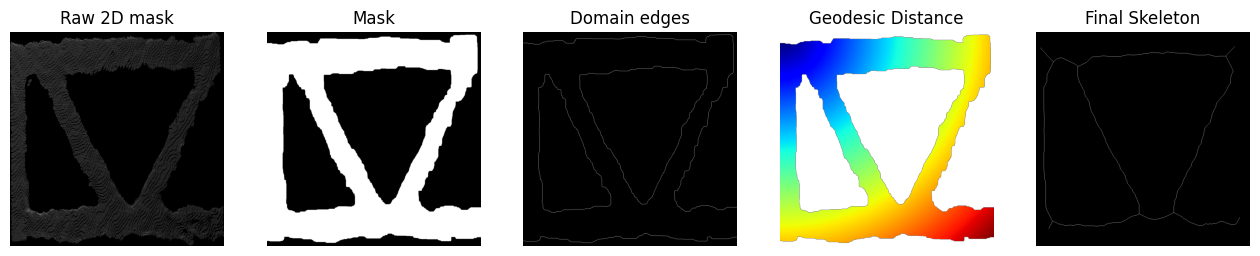

In [4]:
def geodesic_skeletonization(mask):
    # Step 1: find domain edges (design contour)
    contour = find_boundaries(mask, mode="outer").astype(np.uint8)
    # Step 2: find domain boundary (no load edges, just boundary)
    edges = cv2.Canny(mask.astype(np.uint8)*255, 100, 200) // 255
    # Step 3: geodesic distance from boundary
    geo_dist = np.full_like(mask, np.inf, dtype=np.float32)
    geo_dist[mask.astype(bool)] = distance_transform_edt(~edges)[mask.astype(bool)]
    # Step 4: Add design contour (watershed "lake filling")
    map2 = geo_dist + contour.astype(np.float32)
    markers, _ = nd_label(mask)
    map3 = watershed(map2, markers=markers, mask=mask)
    # Step 5: Skeleton = watershed ridges (map3==0) minus outer contour
    skeleton = thin((1 - map3 == 0).astype(np.uint8))
    return skeleton, edges, contour, geo_dist, map2, map3

skeleton, edges, contour, geo_dist, map2, map3 = geodesic_skeletonization(mask)
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
axs[0].imshow(mask2d, cmap='gray'); axs[0].set_title('Raw 2D mask'); axs[0].axis('off')
axs[1].imshow(mask, cmap='gray'); axs[1].set_title("Mask"); axs[1].axis("off")
axs[2].imshow(edges, cmap='gray'); axs[2].set_title("Domain edges"); axs[2].axis("off")
axs[3].imshow(geo_dist, cmap='jet'); axs[3].set_title("Geodesic Distance"); axs[3].axis("off")
axs[4].imshow(skeleton, cmap='gray'); axs[4].set_title("Final Skeleton"); axs[4].axis("off")
plt.show()

### Skeleton Node Detection

#### Detect nodes in the skeleton where branches meet

In [5]:
def find_nodes(skel):
    # Count neighbors for each skeleton pixel
    kernel = np.ones((3, 3), dtype=int)
    neighbor_count = convolve2d(skel, kernel, mode='same', boundary='fill') - skel
    yx = np.argwhere(skel)
    # Find endpoints (1 neighbor), junctions (>=3 neighbors)
    endpoints = [tuple(p) for p in yx if neighbor_count[tuple(p)] == 1]
    junctions = [tuple(p) for p in yx if neighbor_count[tuple(p)] >= 3]
    all_nodes = np.array(endpoints + junctions)
    if len(all_nodes) == 0:
        return [], [], []
    # Cluster all nodes so close points merge
    clustering = DBSCAN(eps=4, min_samples=1).fit(all_nodes)
    merged_nodes = [tuple(np.mean(all_nodes[clustering.labels_==k], axis=0).astype(int)) for k in set(clustering.labels_)]
    # Separate which merged nodes are endpoints/junctions
    endpoint_set = set([tuple(p) for p in endpoints])
    merged_endpoints = [pt for pt in merged_nodes if any(np.linalg.norm(np.array(pt)-np.array(e))<3 for e in endpoints)]
    merged_junctions = [pt for pt in merged_nodes if pt not in merged_endpoints]
    return merged_nodes, merged_junctions, merged_endpoints

nodes, junctions, endpoints = find_nodes(skeleton)
print(f"Total nodes: {len(nodes)}, Junctions: {len(junctions)}, Endpoints: {len(endpoints)}")

Total nodes: 10, Junctions: 6, Endpoints: 4


#### Extract corresponding branches

In [6]:
def extract_branches(skel, nodes):
    branch_masks = []
    G = nx.Graph()
    for i, n1 in enumerate(nodes):
        for j, n2 in enumerate(nodes):
            if i >= j: continue
            cost = 1 - skel.astype(np.uint8)
            try:
                path, _ = route_through_array(cost, n1, n2, fully_connected=True)
            except Exception:
                continue
            if len(path) > 3 and all(skel[tuple(p)] for p in path):
                branch_masks.append(path)
                G.add_edge(i, j, pixels=path)
    return G, branch_masks

G, branch_masks = extract_branches(skeleton, nodes)
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Graph: 10 nodes, 45 edges


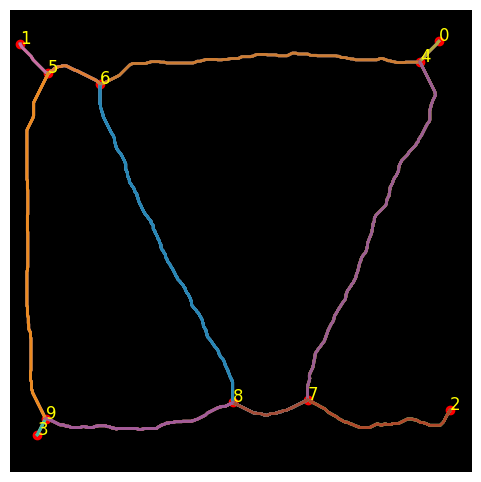

In [7]:
def draw_graph(G, skel, nodes):
    plt.figure(figsize=(6, 6))
    plt.imshow(skel, cmap='gray')
    for i, (y, x) in enumerate(nodes):
        plt.plot(x, y, 'ro')
        plt.text(x, y, f'{i}', color='yellow', fontsize=12)
    for u, v, d in G.edges(data=True):
        pts = np.array(d['pixels'])
        plt.plot(pts[:,1], pts[:,0], linewidth=2, alpha=0.7)
    plt.axis("off")
    plt.show()

draw_graph(G, skeleton, nodes)

#### Branch semantic segmentation (correction)

Branches: 21


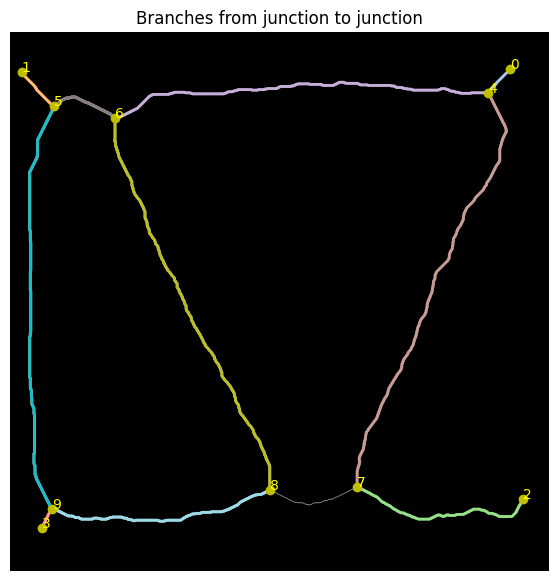

In [8]:
def skeleton_branches(skel, nodes):
    node_map = {tuple(p):i for i,p in enumerate(nodes)}
    visited = np.zeros_like(skel, dtype=bool)
    h, w = skel.shape
    offsets = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
    unique_edges = set()
    branches = []
    neighbors = defaultdict(list)
    # Mark node pixels
    node_mask = np.zeros_like(skel, dtype=bool)
    for y, x in nodes:
        node_mask[y, x] = True
    # For each node, start walk along each neighbor pixel
    for idx, (y0, x0) in enumerate(nodes):
        for dy, dx in offsets:
            y, x = y0+dy, x0+dx
            if 0<=y<h and 0<=x<w and skel[y, x] and not node_mask[y, x]:
                if visited[y, x]: continue
                # start branch
                branch = [(y0, x0)]
                cy, cx = y, x
                prev = (y0, x0)
                while True:
                    branch.append((cy, cx))
                    visited[cy, cx] = True
                    # Find all neighbors on skeleton except previous
                    nb = [(cy+dy, cx+dx) for dy,dx in offsets
                          if 0<=cy+dy<h and 0<=cx+dx<w and skel[cy+dy, cx+dx] and (cy+dy, cx+dx)!=prev]
                    if not nb:
                        break
                    next_nb = nb[0]
                    if node_mask[next_nb]:
                        # Reached another node, close branch
                        branch.append(next_nb)
                        break
                    prev = (cy, cx)
                    cy, cx = next_nb
                # Save only branches between distinct nodes
                if node_mask[branch[0]] and node_mask[branch[-1]] and branch[0] != branch[-1]:
                    branches.append(branch)
                    u = node_map[branch[0]]
                    v = node_map[branch[-1]]
                    if (u, v) not in unique_edges and (v, u) not in unique_edges:
                        branches.append(branch)
                        unique_edges.add((u, v))
                    neighbors[u].append(v)
    return branches, neighbors

branches, node_neighbors = skeleton_branches(skeleton, nodes)
print(f"Branches: {len(branches)}")

colors = plt.colormaps['tab20']
color_vals = [colors(i % 20) for i in range(len(branches))]
plt.figure(figsize=(7,7))
plt.imshow(skeleton, cmap='gray')
for i, branch in enumerate(branches):
    arr = np.array(branch)
    plt.plot(arr[:,1], arr[:,0], color=colors(i), linewidth=2)
for idx, (y,x) in enumerate(nodes):
    plt.plot(x, y, 'yo')
    plt.text(x, y, str(idx), color='yellow')
plt.axis('off')
plt.title('Branches from junction to junction')
plt.show()

### Further tips and tricks for 3D visualization

In [9]:
def nodes2d_to_3d(nodes, img_xy, points):
    # closes 3d pixel from 2d coords
    tree = cKDTree(img_xy)
    node_arr = np.array(nodes)
    dists, idxs = tree.query(node_arr, k=1)
    coords_3d = points[idxs]
    return coords_3d


def skeleton_branches_to_3d(branches, img_xy, points_3d):
    pix_map = {}
    for i, (y, x) in enumerate(img_xy):
        pix_map.setdefault((y, x), []).append(i)
    branches_3d = []
    for branch in branches:
        pts = []
        for y, x in branch:
            inds = pix_map.get((y, x), [])
            pts.extend(points_3d[inds])
        if pts:
            branches_3d.append(np.array(pts))
    return branches_3d


def make_o3d_lineset(branches_3d, node_coords_3d):
    pts, lines, colors = [], [], []
    idx = 0
    cmap = plt.colormaps["tab20"](np.linspace(0, 1, len(branches_3d)))[:, :3]
    for i, b3d in enumerate(branches_3d):
        if len(b3d) < 2:
            continue
        b3d = np.array(b3d)
        pts.extend(b3d)
        lines.extend([[idx + j, idx + j + 1] for j in range(len(b3d) - 1)])
        colors.extend([cmap[i]] * (len(b3d) - 1))
        idx += len(b3d)
    lineset = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(pts),
        lines=o3d.utility.Vector2iVector(lines),
    )
    lineset.colors = o3d.utility.Vector3dVector(colors)
    spheres = [
        o3d.geometry.TriangleMesh.create_sphere(0.002)
        .translate(c)
        .paint_uniform_color([1, 0.2, 0])
        for c in node_coords_3d
    ]
    return [lineset], spheres


img_xy_pix = np.stack([img_xy[:, 1], img_xy[:, 0]], axis=1)
branches_3d = skeleton_branches_to_3d(branches, img_xy_pix, points)
node_coords_3d = nodes2d_to_3d(nodes, img_xy_pix, points)
o3d_branches, o3d_nodes = make_o3d_lineset(branches_3d, node_coords_3d)


def make_graph_lineset(node_coords_3d, branches, nodes, eps=3):
    node_coords_2d = np.array(nodes)
    node_tree = cKDTree(node_coords_2d)
    pairs = set()
    for branch in branches:
        i0 = node_tree.query(branch[0], k=1)[1]
        i1 = node_tree.query(branch[-1], k=1)[1]
        if i0 != i1:
            pairs.add(tuple(sorted((i0, i1))))
    lines = [list(pair) for pair in pairs]
    points = np.array(node_coords_3d)
    color = np.array([[0.0, 0.0, 0.0] for _ in lines])
    graph_lineset = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),
    )
    graph_lineset.colors = o3d.utility.Vector3dVector(color)
    return graph_lineset

In [10]:
def toggle_plane(vis):
    if show_plane["visible"]:
        vis.remove_geometry(plane, reset_bounding_box=False)
    else:
        vis.add_geometry(plane, reset_bounding_box=False)
    show_plane["visible"] = not show_plane["visible"]
    return False


def toggle_graph(vis):
    if show_graph["visible"]:
        vis.remove_geometry(graph_lineset, reset_bounding_box=False)
    else:
        vis.add_geometry(graph_lineset, reset_bounding_box=False)
    show_graph["visible"] = not show_graph["visible"]
    return False


def toggle_nodes(vis):
    if show_nodes["visible"]:
        for node in o3d_nodes:
            vis.remove_geometry(node, reset_bounding_box=False)
    else:
        for node in o3d_nodes:
            vis.add_geometry(node, reset_bounding_box=False)
    show_nodes["visible"] = not show_nodes["visible"]
    return False


def toggle_skeletons(vis):
    if show_skeleton["visible"]:
        for ls in o3d_branches:
            vis.remove_geometry(ls, reset_bounding_box=False)
    else:
        for ls in o3d_branches:
            vis.add_geometry(ls, reset_bounding_box=False)
    show_skeleton["visible"] = not show_skeleton["visible"]
    return False


vis = o3d.visualization.VisualizerWithKeyCallback()
vis.create_window()
vis.add_geometry(plane)
for geom in o3d_nodes + o3d_branches:
    vis.add_geometry(geom)
opt = vis.get_render_option()
opt.line_width = 15
opt.background_color = np.ones(3)
show_plane = {"visible": True}
graph_lineset = make_graph_lineset(node_coords_3d, branches, nodes)
show_graph = {"visible": False}
show_nodes = {"visible": True}
show_skeleton = {"visible": True}

vis.register_key_callback(ord("G"), toggle_plane)
vis.register_key_callback(ord("H"), toggle_graph)
vis.register_key_callback(ord("J"), toggle_skeletons)
vis.register_key_callback(ord("N"), toggle_nodes)
vis.run()
vis.destroy_window()

### Stats

In [11]:
def compute_graph_stats(G, nodes, seg3d):
    print(f"Total nodes: {len(nodes)}")
    print(f"Total branches: {G.number_of_edges()}")
    branch_lengths = []
    for i, pts in enumerate(seg3d):
        if len(pts) > 1:
            dists = np.linalg.norm(np.diff(pts, axis=0), axis=1)
            branch_lengths.append(dists.sum())
    print(f"Branch length mean: {np.mean(branch_lengths):.2f}, std: {np.std(branch_lengths):.2f}")

compute_graph_stats(G, nodes, branches_3d)

Total nodes: 10
Total branches: 45
Branch length mean: 0.08, std: 0.06
